# FORM

In [11]:
import datetime
import ipywidgets as widgets
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from IPython.display import clear_output
from traitlets import traitlets

In [12]:
from IPython.display import HTML, display

display(HTML("""<style>
    .widget-label { min-width: 30ex !important; }
</style>"""))

pd.set_option('expand_frame_repr', False)

In [13]:
class LoadedButton(widgets.Button):
    """A button that can holds a value as a attribute."""

    def __init__(self, value=None, *args, **kwargs):
        super(LoadedButton, self).__init__(*args, **kwargs)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))

## Examples

### Initiate empty workout DataFrame

In [14]:
columns = ["Date", "Exercise", "Tool", "Weight (kg)", "Series", "Reps", "Rest", "Duration", "Order", "Notes"]
workout = pd.DataFrame(columns=columns)

### Get necessary data

In [15]:
df = pd.read_csv("./data/raw/workouts/exercises/exercises.csv", header=0)
df = df[["Exercise", "Group", "Tool"]].sort_values(by=["Group", "Exercise", "Tool"])

### Build form

In [6]:
exercises_by_groups = df.groupby("Group")["Exercise"].apply(list).to_dict()
tools_by_exercises = df.groupby("Exercise")["Tool"].apply(list).to_dict()

layout = widgets.Layout(width="95%",
                        height="auto",
                        #border="1px solid black"
                        #margin="0px 0px 0px 0px", # top, right, bottom, left
                        #padding="0px 0px 0px 0px"
                       )

date_field = widgets.DatePicker(value=datetime.datetime.now(),
                                description="Date:",
                                placeholder="Enter date (YYYYMMDD)",
                                layout=layout
                               )

groups_select = widgets.Select(value="Back",
                               description="Group worked:",
                               options=exercises_by_groups.keys(),
                               layout=layout
                              )

exercises_select = widgets.Select(description="Exercise:",
                                  layout=layout
                                 )

tools_select = widgets.Select(description="Tool:",
                              layout=layout
                             )

series_slider = widgets.IntSlider(value=3,
                                  min=1,
                                  max=50,
                                  step=1,
                                  description="# of series: (if going for count)",
                                  #disabled=False,
                                  #continuous_update=False,
                                  orientation="horizontal",
                                  readout=True,
                                  readout_format="d",
                                  layout=layout
                                 )

reps_field = widgets.IntText(value=12,
                             step=1,
                             description="Reps:",
                             layout=layout
                            )


weights_field = widgets.FloatText(value=12.5,
                                  step=0.5,
                                  description="Weight (kg):",
                                  layout=layout
                                 )

rest_field = widgets.IntText(value=45,
                             description="Resting time (s):",
                             layout=layout
                            )

duration_field = widgets.IntText(value=45,
                                 description="Did each round for (if going for time):",
                                 layout=layout
                                )

duration_select = widgets.Select(options=["seconds", "minutes"],
                                 description="Duration unit:",
                                 layout=layout
                                )

notes_field = widgets.Textarea(value="",
                               placeholder="Optional comments on the exercise",
                               description="Notes:",
                               layout=layout
                              )

def update_options(*args): # *args represent zero (case here) or more arguments.
    exercises_select.options = exercises_by_groups[groups_select.value]
    def update_tool(*args):
        tools_select.options = tools_by_exercises[exercises_select.value]
    exercises_select.observe(update_tool)
    #tools_select.options = tools_by_exercises[exercises_select.value]

groups_select.observe(update_options) # Here is the trick, i.e. update exercises.options based on groups.value

#---
@widgets.interact(date = date_field,
                  group = groups_select,
                  exercise = exercises_select,
                  tool = tools_select,
                  series_count = series_slider,
                  reps = reps_field,
                  weight = weights_field,
                  rest = rest_field,
                  duration = duration_field,
                  duration_unit = duration_select,
                  notes = notes_field
                 )
def print_options(date, group, exercise, tool, series_count, reps, weight, rest, duration, duration_unit, notes):
    print(f"\nLogging workout for {date.strftime('%Y-%m-%d')}:\n{exercise} - {tool}: {series_count} series x {reps} repetitions x {weight}kg with {rest}s of rest.\nNotes: {notes}")
    
button_save = LoadedButton(description='Save exercise',
                           tooltip='Click here to save the current results as a row in your exercise logs.',
                           layout=layout
                          )

button_remove = LoadedButton(description='Remove last row',
                             tooltip='Click here to remove the last row that was added.',
                             layout=layout
                          )

#default_exercise = df[df["Group"]==groups_select.value]["Exercise"].unique()[0]
#exercises_select.value = default_exercise
#default_tool = df[(df["Group"]==groups_select.value) and (df["Exercise"]==exercises_select.value)]["Exercise"].unique()[0]
#tools_select.value = default_tool

output = widgets.Output(value=workout,
                        button_style="success",
                        layout=layout
                       )

display(button_save, button_remove, output)

def on_save_button_clicked(*args):
    with output:
        clear_output()
        if duration_select.value == "minutes":
            duration_seconds = duration_field.value * 60
            rest_seconds = rest_field.value * 60
        else:
            duration_seconds = duration_field.value
            rest_seconds = rest_field.value
        print(rest_seconds)
        row = {"Date": [date_field.value.strftime("%Y-%m-%d")],
               "Exercise": [exercises_select.value],
               "Tool": [tools_select.value],
               "Weight (kg)": [weights_field.value],
               "Series": [series_slider.value],
               "Reps": [reps_field.value],
               "Rest": [rest_field.value],
               "Duration": [duration_seconds],
               "Order": [np.nan],
               "Notes": [notes_field.value]
              }
    
        row = pd.DataFrame.from_dict(row)
        global workout
        workout = pd.concat(objs=[args[0], row]).reset_index(drop=True)
        output.value = workout
        row_title = "Added row:"
        print(f"{'_'*len(row_title)}\n{row_title}")
        print(row.head())
        workout_title = "New log state"
        print(f"{'_'*len(workout_title)}\n{workout_title}")
        print(workout)
        
def on_remove_button_clicked(*args):
    with output:
        clear_output()
        global workout
        row = workout.tail(1)
        workout = workout.drop(workout.tail(1).index).reset_index(drop=True)
        output.value = workout
        row_title = "Removed row:"
        print(f"{'_'*len(row_title)}\n{row_title}")
        print(row.head())
        workout_title = "New log state"
        print(f"{'_'*len(workout_title)}\n{workout_title}")
        print(workout)
    
button_save.on_click(lambda x: on_save_button_clicked(workout))
button_remove.on_click(lambda x: on_remove_button_clicked(workout))

interactive(children=(DatePicker(value=datetime.datetime(2022, 7, 25, 18, 14, 42, 597082), description='Date:'…

LoadedButton(description='Save exercise', layout=Layout(height='auto', width='95%'), style=ButtonStyle(), tool…

LoadedButton(description='Remove last row', layout=Layout(height='auto', width='95%'), style=ButtonStyle(), to…

Output(layout=Layout(height='auto', width='95%'))

___

### Add order column and check output

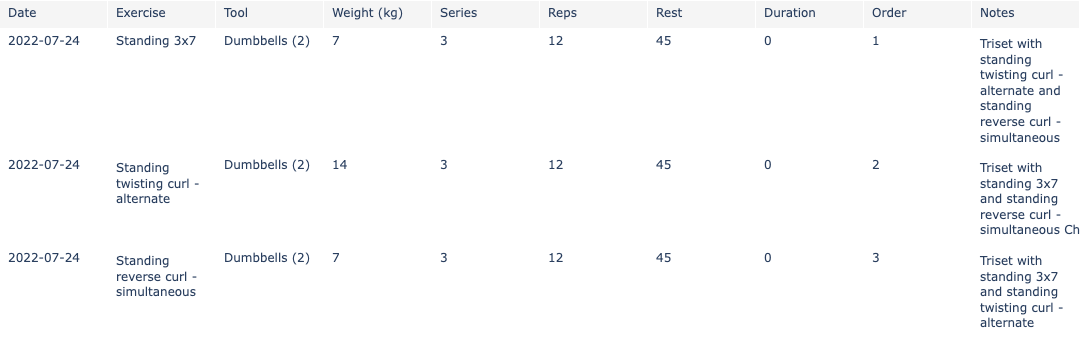

In [23]:
custom_layout = {"autosize": True,
                 #width=1000,
                 #height=500,
                 "margin": {
                   "l": 0,
                   "r": 0,
                   "b": 0,
                   "t": 0,
                  }
                  #paper_bgcolor="lightseagreen",}
                }

workout["Order"] = [i for i in range(1, len(workout)+1)]

fig = go.Figure(data=[go.Table(
    header=dict(values=workout.columns,
                fill_color="whitesmoke",
                align="left"),
    cells=dict(values=[workout[col] for col in workout.columns],
               fill_color="white",
               align="left"))
])

fig.update_layout(custom_layout)

fig.show()

### Save log

In [24]:
workout.to_csv(f"./data/raw/workouts/logs/{date_field.value.strftime('%Y%m%d')}.csv", index=False)